# Proyek Klasifikasi Gambar: Plastic - Paper - Garbage Bag Synthetic Images Dataset
- **Nama:** Sindi Aprilianti
- **Email:** apriliantisindi29@gmail.com
- **ID Dicoding:** sindi aprilianti

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import shutil
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


## Data Preparation

### Data Loading

Dataset yang digunakan: Plastic - Paper - Garbage Bag Synthetic Images Dataset

https://www.kaggle.com/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"apriliantisindi","key":"a78b4e46c153dec6b755534bcd23bf7c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!mkdir -p /content/datasets/bag
!kaggle datasets download -d vencerlanz09/plastic-paper-garbage-bag-synthetic-images -p /content/datasets/bag
!unzip /content/datasets/bag/plastic-paper-garbage-bag-synthetic-images.zip -d /content/datasets/bag


Streaming output truncated to the last 5000 lines.
  inflating: /content/datasets/bag/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010001.jpg  
  inflating: /content/datasets/bag/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010002.jpg  
  inflating: /content/datasets/bag/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010003.jpg  
  inflating: /content/datasets/bag/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010004.jpg  
  inflating: /content/datasets/bag/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010005.jpg  
  inflating: /content/datasets/bag/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010006.jpg  
  inflating: /content/datasets/bag/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010007.jpg  
  inflating: /content/datasets/bag/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010008.jpg  
  inflating: /content/datasets/bag/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010009.jpg  
  inflating: /content/datasets/bag/Image

In [ ]:
# cek list folder yang ada
!ls /content

datasets  kaggle.json  sample_data


In [ ]:
# untuk melihat resolusi gambar dan total entry data
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue

        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution("datasets/bag/Bag Classes/Bag Classes")


Paper Bag Images: 5000
- (300, 300)
---------------
Garbage Bag Images: 5000
- (300, 300)
---------------
Plastic Bag Images: 5000
- (300, 300)
---------------

Total: 15000


Total gambar pada dataset sebanyak 15000 gambar.

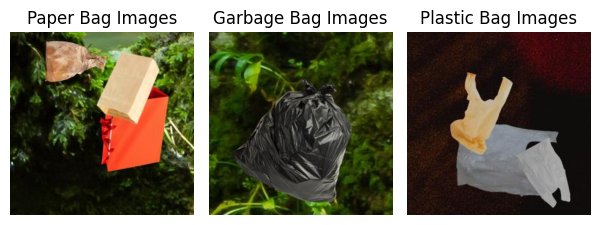

In [ ]:
import os
import matplotlib.pyplot as plt

def load_images_from_folder(folder_path):
    dataset = []
    for kelas in os.listdir(folder_path):
        kelas_path = os.path.join(folder_path, kelas)

        if os.path.isdir(kelas_path):
            for file in os.listdir(kelas_path):
                file_path = os.path.join(kelas_path, file)
                if os.path.isfile(file_path):
                    img = plt.imread(file_path)
                    dataset.append({
                        "img": img,
                        "folder": kelas
                    })
                    break
    return dataset

# untuk menampilkan gambar
def show_images(dataset):
    plt.figure(figsize=(20, 8))
    for i, sample_item in enumerate(dataset):
        plt.subplot(3, 10, i + 1)
        plt.imshow(sample_item["img"])
        plt.title(sample_item["folder"])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# memuat dataset
dataset = load_images_from_folder("datasets/bag/Bag Classes/Bag Classes")
show_images(dataset)


### Data Preprocessing

#### Split Dataset

membagi dataset menjadi train 70%, validation 15%, dan test 15%

In [ ]:
# menentukan path untuk penyimpanan dataset
dataset_dir = "datasets/bag/Bag Classes/Bag Classes"
train_dir = "/content/datasets/split/train"
validation_dir = "/content/datasets/split/validation"
test_dir = "/content/datasets/split/test"

# buat dir untuk train, validation, dan test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)

    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if len(image_files) == 0:
            continue

        # membuat dir untuk train, validation, dan test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # split dataset menjadi train 70%, validation 15%, dan test 15%
        train_images, temp_images = train_test_split(image_files, test_size=0.3, random_state=42)
        validation_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

        # menyalin gambar ke folder
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in validation_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(validation_dir, class_name, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("split dataset telah selesai dilakukan")


split dataset telah selesai dilakukan


In [ ]:
def hitung_jumlah_data(folder_path):
     kelas_count = {}
     total = 0

     for kelas in os.listdir(folder_path):
         kelas_path = os.path.join(folder_path, kelas)
         if os.path.isdir(kelas_path):
             jumlah_file = len([
                 f for f in os.listdir(kelas_path)
                 if os.path.isfile(os.path.join(kelas_path, f))
             ])
             kelas_count[kelas] = jumlah_file
             total += jumlah_file

     print(f"Jumlah data di folder '{folder_path}':")
     for kelas, count in kelas_count.items():
         print(f"  {kelas}: {count}")
     print(f"  Total: {total}\n")

 # Cek jumlah data di masing-masing folder
hitung_jumlah_data(train_dir)
hitung_jumlah_data(validation_dir)
hitung_jumlah_data(test_dir)


Jumlah data di folder '/content/datasets/split/train':
  Paper Bag Images: 3500
  Garbage Bag Images: 3500
  Plastic Bag Images: 3500
  Total: 10500

Jumlah data di folder '/content/datasets/split/validation':
  Paper Bag Images: 750
  Garbage Bag Images: 750
  Plastic Bag Images: 750
  Total: 2250

Jumlah data di folder '/content/datasets/split/test':
  Paper Bag Images: 750
  Garbage Bag Images: 750
  Plastic Bag Images: 750
  Total: 2250



augmentasi gambar

In [ ]:

datagen = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

test_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(train_dir,
      batch_size=32,
      target_size=(224,224),
      class_mode='categorical',
      shuffle=True)

validation_generator = datagen.flow_from_directory(validation_dir,
      batch_size=32,
      target_size=(224,224),
      class_mode='categorical',
      shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
      batch_size=32,
      target_size=(224,224),
      class_mode='categorical',
      shuffle=False)

Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.


## Modelling

In [ ]:
# menggunakan MobileNetV2
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in pre_trained_model.layers:
    layer.trainable = False

model = Sequential()
model.add(pre_trained_model)

# menambahkan layer pooling dan konvolusi
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# globalAverage dan fully connected layers
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dense(3, activation='softmax')) # output layer ada 3 kelas

# compile model
model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,696,355 (10.29 MB)

 Trainable params: 437,731 (1.67 MB)

 Non-trainable params: 2,258,624 (8.62 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# training
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 208s 583ms/step - accuracy: 0.8353 - loss: 0.4026 - val_accuracy: 0.9680 - val_loss: 0.0833
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 175s 531ms/step - accuracy: 0.9637 - loss: 0.1026 - val_accuracy: 0.9684 - val_loss: 0.0843
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 178s 539ms/step - accuracy: 0.9646 - loss: 0.1045 - val_accuracy: 0.9769 - val_loss: 0.0640
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 145s 441ms/step - accuracy: 0.9692 - loss: 0.0925 - val_accuracy: 0.9831 - val_loss: 0.0445
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 144s 437ms/step - accuracy: 0.9621 - loss: 0.0997 - val_accuracy: 0.9769 - val_loss: 0.0531
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 208s 456ms/step - accuracy: 0.9733 - loss: 0.0800 - val_accuracy: 0.9800 - val_loss: 0.0514
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 148s 449ms/step - accuracy: 0.9728 - loss: 0.0824 - val_accuracy: 0.9796 - val_loss: 0.0493
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 143s 435ms/step - accuracy: 0.9797 -

## Evaluasi dan Visualisasi

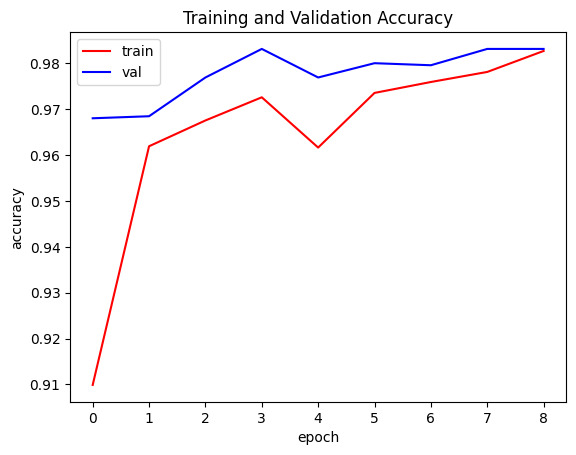

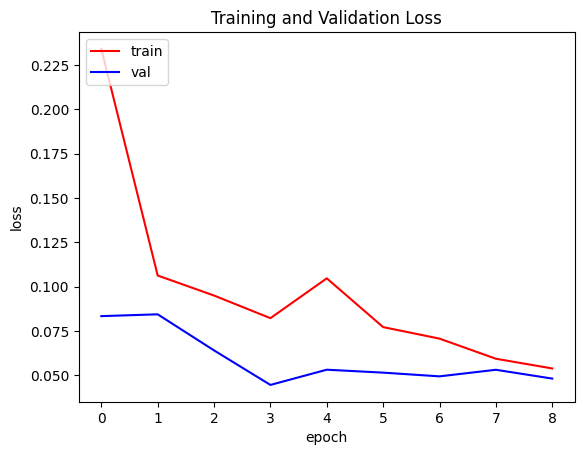

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.9892 - loss: 0.0269


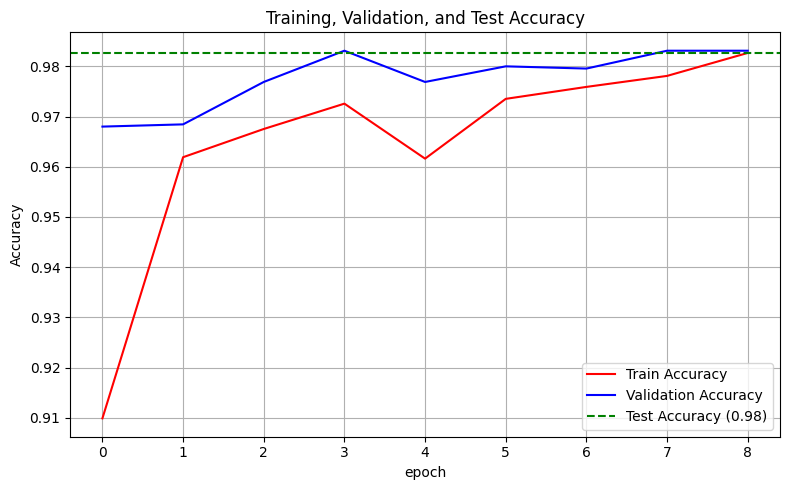

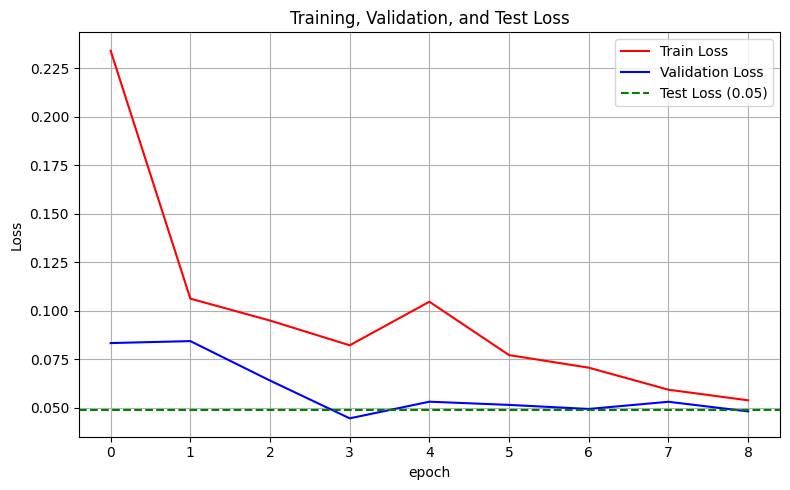

In [ ]:
# testing
model = load_model('best_model.keras')
test_loss, test_acc = model.evaluate(test_generator)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(acc, 'r', label='Train Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.axhline(y=test_acc, color='g', linestyle='--', label=f'Test Accuracy ({test_acc:.2f})')
plt.title('Training, Validation, and Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(loss, 'r', label='Train Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.axhline(y=test_loss, color='g', linestyle='--', label=f'Test Loss ({test_loss:.2f})')
plt.title('Training, Validation, and Test Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Konversi Model

In [ ]:
# model h5
model.save("model.h5")

In [ ]:
# model TFJS
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-04-30 10:03:13.249336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746007393.269954   11283 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746007393.277056   11283 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
# savedmodel
save_path = os.path.join("/content/")
tf.saved_model.save(model, save_path)

In [ ]:
# TF lite
model = tf.keras.models.load_model('/content/model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/content/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp__qy87q4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140367930490512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367930489168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367930488784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367930488976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367930490320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367930487632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367930487248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367930486864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367930487056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367930489744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1403679304857

## requirements

In [ ]:
!pip freeze > requirements.txt